## Librerías Utilizadas

- `isbnlib`: Para validar y trabajar con números ISBN.
- `pandas`: Utilizada para la manipulación y análisis de datos.
- `matplotlib.pyplot`: Usada para crear visualizaciones y gráficos.
- `sklearn.preprocessing`: Proporciona herramientas para la codificación de etiquetas y el procesamiento de datos.
- `sklearn.model_selection`: Utilizada para dividir los datos en conjuntos de entrenamiento y prueba.
- `tensorflow.keras.models`: Permite crear modelos de aprendizaje profundo.
- `tensorflow.keras.layers`: Proporciona capas para construir redes neuronales, como `Input`, `Embedding`, `Flatten`, `Dense` y `Concatenate`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

## Paso 1: Preparación de los Datos

Primero, cargamos los datos preprocesados desde archivos CSV. Usamos `LabelEncoder` para convertir identificadores únicos de usuarios y libros en valores numéricos que el modelo de redes neuronales puede procesar.


In [4]:
# Cargar los datos
train_usuarios_calificaciones = pd.read_csv('train_usuarios_calificaciones.csv',low_memory=False)
test_usuarios_calificaciones = pd.read_csv('test_usuarios_calificaciones.csv',low_memory=False)

# Codificar categóricamente las variables necesarias
label_encoder_user = LabelEncoder()
label_encoder_book = LabelEncoder()

# Ajustar LabelEncoder a todos los datos (entrenamiento y prueba) para 'User-ID' y 'ISBN'
label_encoder_user.fit(pd.concat([train_usuarios_calificaciones['User-ID'], test_usuarios_calificaciones['User-ID']]).unique())
label_encoder_book.fit(pd.concat([train_usuarios_calificaciones['ISBN'], test_usuarios_calificaciones['ISBN']]).unique())

# Transformar los datos de entrenamiento y prueba
train_usuarios_calificaciones['User-ID'] = label_encoder_user.transform(train_usuarios_calificaciones['User-ID'])
test_usuarios_calificaciones['User-ID'] = label_encoder_user.transform(test_usuarios_calificaciones['User-ID'])

train_usuarios_calificaciones['ISBN'] = label_encoder_book.transform(train_usuarios_calificaciones['ISBN'])
test_usuarios_calificaciones['ISBN'] = label_encoder_book.transform(test_usuarios_calificaciones['ISBN'])

# Asegurarse de que no haya valores NaN en las columnas de calificaciones
train_usuarios_calificaciones.dropna(subset=['Book-Rating'], inplace=True)
test_usuarios_calificaciones.dropna(subset=['Book-Rating'], inplace=True)

## Paso 2: Construcción del Modelo

Construimos un modelo de aprendizaje profundo utilizando Keras. El modelo implementa embeddings para usuarios y libros, y utiliza una red neuronal densa para predecir las calificaciones de los libros.


In [8]:
# Número de factores de embeddings
embedding_size = 15

# Inputs
user_input = Input(shape=(1,), name='user_input')
book_input = Input(shape=(1,), name='book_input')

# Embeddings
max_user_id = train_usuarios_calificaciones['User-ID'].max() + 1
max_book_id = train_usuarios_calificaciones['ISBN'].max() + 1

user_embedding = Embedding(input_dim=max_user_id, 
                           output_dim=embedding_size, 
                           name='user_embedding')(user_input)
book_embedding = Embedding(input_dim=max_book_id, 
                           output_dim=embedding_size, 
                           name='book_embedding')(book_input)


# Aplanamiento
user_vec = Flatten(name='flatten_user')(user_embedding)
book_vec = Flatten(name='flatten_book')(book_embedding)

# Concatenación
concat = Concatenate()([user_vec, book_vec])

# Red neuronal
dense_1 = Dense(128, activation='relu')(concat)
output = Dense(1, activation='linear')(dense_1)

# Modelo
model = Model(inputs=[user_input, book_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

## Paso 3: Entrenamiento y Evaluación del Modelo

Entrenamos el modelo con los datos de entrenamiento y lo evaluamos con los datos de prueba para medir su rendimiento.


In [9]:
# Datos de entrenamiento
X_train = [train_usuarios_calificaciones['User-ID'].values, train_usuarios_calificaciones['ISBN'].values]
y_train = train_usuarios_calificaciones['Book-Rating'].values

# Entrenamiento del modelo
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Datos de prueba
X_test = [test_usuarios_calificaciones['User-ID'].values, test_usuarios_calificaciones['ISBN'].values]
y_test = test_usuarios_calificaciones['Book-Rating'].values

# Evaluación del modelo
model.evaluate(X_test, y_test)

Epoch 1/5
26948/26948 [==============================] - 1888s 70ms/step - loss: 11.7187
Epoch 2/5
26948/26948 [==============================] - 1780s 66ms/step - loss: 9.3842
Epoch 3/5
26948/26948 [==============================] - 1775s 66ms/step - loss: 7.9036
Epoch 4/5
26948/26948 [==============================] - 1775s 66ms/step - loss: 6.9673
Epoch 5/5
8983/8983 [==============================] - 11s 1ms/step - loss: 12.9595


12.959489822387695

## Paso 4: Visualización de Resultados

Visualizamos los resultados del modelo para comprender mejor su rendimiento. Generamos un histograma de los errores de predicción para analizar la distribución de estos errores.

8983/8983 [==============================] - 11s 1ms/step


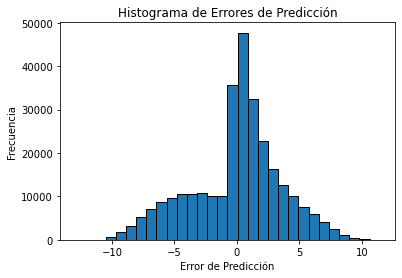

In [13]:
# Genera predicciones del modelo
predictions = model.predict(X_test).flatten()  # Asegúrate de que sea un vector unidimensional

# Extrae los valores verdaderos y asegúrarse de que sean unidimensionales
true_values = y_test.flatten()

# Verificar que ambos vectores tengan la misma longitud
if len(predictions) != len(true_values):
    raise ValueError(f"Las longitudes no coinciden: {len(predictions)} vs {len(true_values)}")

# Calcula los errores
errors = predictions - true_values

# Grafica un histograma de los errores
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Histograma de Errores de Predicción')
plt.show()

## Paso 5: Conclusiones 

La forma del histograma indica lo siguiente:

La mayoría de los errores se concentran alrededor de cero, lo que implica que para muchos casos, las predicciones del modelo estuvieron muy cerca del valor real.
La distribución de los errores parece ser aproximadamente normal (con forma de campana), lo que es un buen signo en cuanto a la precisión del modelo. En la práctica, un modelo de predicción raramente es perfecto, pero un error centrado alrededor de cero con una distribución simétrica es a menudo deseable.
No hay una gran cantidad de errores extremadamente grandes en ninguna de las dos direcciones (positiva o negativa), lo que indicaría que el modelo no tiene tendencia sistemática a sobrestimar o subestimar significativamente las calificaciones.

## Guardamos modelo para trabajar en producción

In [18]:
# Para un modelo de Keras/TensorFlow
model.save('training_model_try_recommender.h5')